## Preprocessing Data

## Import Data

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c sentiment-analysis-on-movie-reviews

Saving kaggle.json to kaggle.json
  0% 0.00/1.90M [00:00<?, ?B/s]
100% 1.90M/1.90M [00:00<00:00, 175MB/s]


In [ ]:
!unzip sentiment-analysis-on-movie-reviews.zip

Archive:  sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [ ]:
!unzip test.tsv.zip
!unzip train.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                
Archive:  train.tsv.zip
  inflating: train.tsv               


## Preparing Data

In [ ]:
import pandas as pd
df=pd.read_csv('train.tsv',sep='\t')
df.head(), df.describe()

(   PhraseId  SentenceId                                             Phrase  \
 0         1           1  A series of escapades demonstrating the adage ...   
 1         2           1  A series of escapades demonstrating the adage ...   
 2         3           1                                           A series   
 3         4           1                                                  A   
 4         5           1                                             series   
 
    Sentiment  
 0          1  
 1          2  
 2          2  
 3          2  
 4          2  ,
             PhraseId     SentenceId      Sentiment
 count  156060.000000  156060.000000  156060.000000
 mean    78030.500000    4079.732744       2.063578
 std     45050.785842    2502.764394       0.893832
 min         1.000000       1.000000       0.000000
 25%     39015.750000    1861.750000       2.000000
 50%     78030.500000    4017.000000       2.000000
 75%    117045.250000    6244.000000       3.000000
 max    156

In [ ]:
# 'SentenceId' means value for each of these copies
df1=df.drop_duplicates(subset=['SentenceId'], keep='first')
df1.head(), df1.describe()

(     PhraseId  SentenceId                                             Phrase  \
 0           1           1  A series of escapades demonstrating the adage ...   
 63         64           2  This quiet , introspective and entertaining in...   
 81         82           3  Even fans of Ismail Merchant 's work , I suspe...   
 116       117           4  A positively thrilling combination of ethnogra...   
 156       157           5  Aggressive self-glorification and a manipulati...   
 
      Sentiment  
 0            1  
 63           4  
 81           1  
 116          3  
 156          1  ,
             PhraseId   SentenceId    Sentiment
 count    8529.000000  8529.000000  8529.000000
 mean    81492.254543  4269.683433     2.063196
 std     44268.957774  2466.705592     1.276636
 min         1.000000     1.000000     0.000000
 25%     43992.000000  2133.000000     1.000000
 50%     82655.000000  4268.000000     2.000000
 75%    119774.000000  6406.000000     3.000000
 max    156040.0000

<Axes: xlabel='Sentiment'>

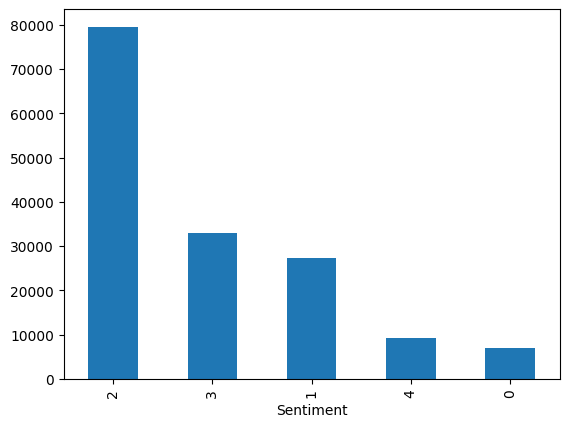

In [ ]:
df['Sentiment'].value_counts().plot(kind='bar')

<Axes: xlabel='Sentiment'>

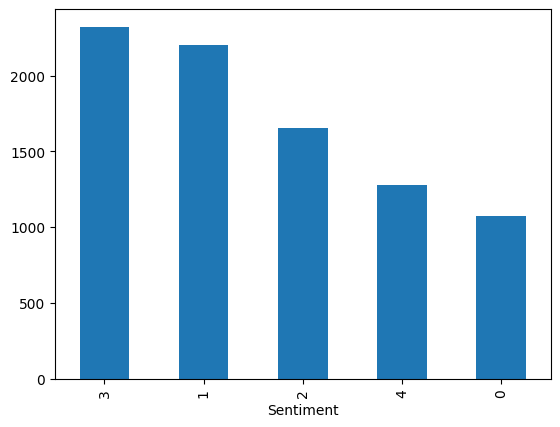

In [ ]:
df1['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
import numpy as np
seq_len=512
num_samples=len(df)

#'np'=numpy,'tf'=tensorflow,'pt'=pytorch
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')
tokens=tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                 truncation=True, padding='max_length',
                 add_special_tokens=True, return_tensors='np')
tokens.keys()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens['input_ids'].shape, tokens['attention_mask'].shape

((156060, 512), (156060, 512))

In [ ]:
tokens['input_ids'][:10], tokens['attention_mask'][:10]

(array([[  101,   138,  1326, ...,     0,     0,     0],
        [  101,   138,  1326, ...,     0,     0,     0],
        [  101,   138,  1326, ...,     0,     0,     0],
        ...,
        [  101, 13936, 25265, ...,     0,     0,     0],
        [  101, 13936, 25265, ...,     0,     0,     0],
        [  101, 15107,  1103, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

Save them to a file as NumPy binary format

In [ ]:
with open('movie_xids.npy', 'wb') as f:
  np.save(f, tokens['input_ids'])
with open('movie_xmasks.npy', 'wb') as f:
  np.save(f, tokens['attention_mask'])

Delete the in-memory arrys to free up memory

In [ ]:
del tokens

Now one-hot-encode labels to a numpy arry

In [ ]:
arr=df['Sentiment'].values
labels=np.zeros((num_samples, arr.max()+1)) # For correct position
labels[np.arange(num_samples), arr]=1
labels

with open('movie_labels.npy', 'wb') as f:
  np.save(f, labels)

## Building a dataset, Input Pipeline

### Create TF dataset object using `from_tensor_slices`

In [ ]:
import numpy as np
with open('movie_xids.npy', 'rb') as f:
  xids=np.load(f, allow_pickle=True)
with open('movie_xmasks.npy', 'rb') as f:
  xmasks=np.load(f, allow_pickle=True)
with open('movie_labels.npy', 'rb') as f:
  labels=np.load(f, allow_pickle=True)

import tensorflow as tf
dataset=tf.data.Dataset.from_tensor_slices((xids, xmasks, labels))
dataset.take(1) # Take one to see the first entry

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Now, each sample inside the `dataset` is a tuple containing a single `xids, xmask, labels` tensor. However, when feeding data into our model, we need a two-item tuple in the format `(<inputs>, <outputs>)`. Since we have two tensors for our inputs, what we do is to enter the `(<inputs>)` tensor as a dict as:

{
  'input_ids':<input_id_tensor>,
  'attention_mask':<mask_tensor>
}

To rearrange dataset format, can use `map` function.

In [ ]:
def map_func(input_ids, masks, labels):
  return {'input_ids':input_ids, 'attention_mask':masks}, labels
  # Since Bert accept two element, which first is dict, and 2nd is labels
# then apply map
dataset=dataset.map(map_func)
dataset.take(1) # Check entry

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

### Dataset Shuffling, Batch, Split and Save

Make sure to shuffle dataset before applying `batch` on it, to make sure the data mix within each batch. Apply `drop_remainder` to ensure consistent input shape, model compatibility, efficiency, simplified training loop, etc.

In [ ]:
batch_size=16
dataset=dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
split=0.8
size=int((xids.shape[0] / batch_size) * split)
train_ds=dataset.take(size)
val_ds=dataset.skip(size) # Skip the first (amount of size) data

#Save file
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


### Find out files' element spec

In [ ]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
train_ds.element_spec == val_ds.element_spec

True

Test loading file

In [ ]:
ds=tf.data.experimental.load('train', element_spec=train_ds.element_spec)
ds.take(1)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## Build and Save

In [ ]:
from transformers import TFAutoModel
bert=TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf
input_ids=tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask=tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')
#[0]=Sequence Output; [1]=Pooled Output
embeddings=bert.bert(input_ids, attention_mask=mask)[1]
x=tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y=tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

#Initialize Model
model=tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.layers[2].trainable=False #Freeze embedding layer (BERT)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
optimizer = tf.keras.optimizers.legacy.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.10/dist-packages/tf_keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

#Load train_ds & val_ds
train_ds=tf.data.experimental.load('train', element_spec=element_spec)
val_ds=tf.data.experimental.load('val', element_spec=element_spec)

#View input format
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
4203/7803 [===============>..............] - ETA: 41:19 - loss: 1.1745 - accuracy: 0.5355

Training takes too long time, might just not train it.

In [ ]:
model.save('sentiment_model')

## Load and predict model

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('sentiment_model')
model.summary()

Before making predictions, make sure to format data:
  - Tokenize data using `bert-base-cased` tokenizer
  - Transforming data into dictionary containing `input_ids` and `attention_mask` tensors

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
  tokens=tokenizer.encode_plus(text, max_length=512, truncation=True,
                               padding='max_length', add_special_toekn=True,
                               return_token_type_ids=False, return_tensors='tf')
  # Return `int32` tensors by default, use `tf.cast` to return `float64`
  return {'input_ids':tf.cast(tokens['input_ids'], tf.float64),
          'attention_mask':tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
probs=model.predict(prep_data("I loved the movie"))[0]
probs

In [ ]:
import numpy as np
np.argmax(probs)

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

df=pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df=df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
# Initialize new sentiment column to store predicted sentiment from model
df['Sentiment']=None

for i, row in df.iterrows():
  tokens=prep_data(row.Phrase)
  probs=model.predict(tokens)
  pred=np.argmax(probs) #tf.math.argmax(probs)
  df.at[i, 'Sentiment']=pred

df.head(), df.tail()